In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import itertools
import os
import time

# allow for .py files in canine package to be added
import sys
sys.path.insert(0, '../')

from canine.preprocessing import datahandler
from canine.plotting import results

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# used to reload .py files in src directory
%load_ext autoreload
%autoreload 2

In [2]:
# only show error messages from tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

VOL = '/mnt/data1/stock/misc/canine'
DSIZE = (224, 224) # (32, 32) (64, 64) (224, 224)
NPY_IMAGE_PATH = os.path.join(VOL, f'images_{DSIZE[0]}x{DSIZE[1]}.npy')
NPY_LABEL_PATH = os.path.join(VOL, f'labels.npy')

ConvNet_saved_model = '../../models/ConvNet-Dog'
MobileNetV2_saved_model = '../../models/MobileNetV2-Dog'
ResNet50V2_saved_model = '../../models/ResNet50V2-Dog'
EfficientNetB4_saved_model = '../../models/EfficientNetB4-Dog'

gpus = tf.config.get_visible_devices('GPU')
for i, device in enumerate(gpus):
    print(device)
    tf.config.experimental.set_memory_growth(device, True)
# !nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


# Data Loader

In [88]:
# (optional) save the data to an np.array 

datahandler.save_data(VOL, NPY_IMAGE_PATH, NPY_LABEL_PATH, DSIZE)

finished saving images to /mnt/data1/stock/misc/canine/images_64x64.npy
finished saving labels to /mnt/data1/stock/misc/canine/labels.npy


In [183]:
images, labels, class_labels = datahandler.load_data(NPY_IMAGE_PATH, NPY_LABEL_PATH, 
                                                     normalize=True, remove_undefined=True)

Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest = datahandler.partition_data(images, labels, 
                                                                           partition=(0.75,0.10,0.15), 
                                                                           shuffle=True)

print(class_labels)
print(Xtrain.shape, Ttrain.shape, Xvalidate.shape, Tvalidate.shape, Xtest.shape, Ttest.shape)

['lying' 'sitting' 'standing']
(10703, 224, 224, 3) (10703, 1) (1427, 224, 224, 3) (1427, 1) (2140, 224, 224, 3) (2140, 1)


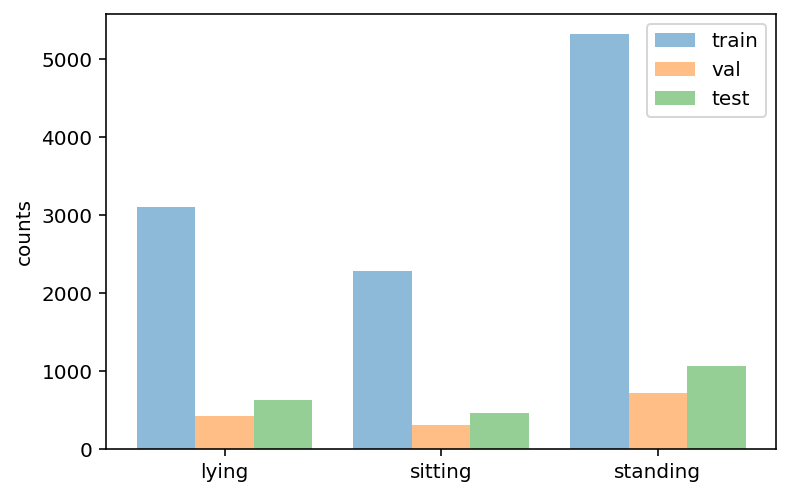

In [95]:
ind = np.arange(len(class_labels))
width = 0.27 # the width of the bars

fig, ax = plt.subplots(figsize=(6, 4))

_, counts = np.unique(Ttrain, return_counts=True)
rects1 = ax.bar(ind, counts, width, alpha=0.5)
_, counts = np.unique(Tvalidate, return_counts=True)
rects2 = ax.bar(ind+width, counts, width, alpha=0.5)
_, counts = np.unique(Ttest, return_counts=True)
rects3 = ax.bar(ind+width*2, counts, width, alpha=0.5)

ax.set_ylabel('counts')
ax.set_xticks(ind+width)
ax.set_xticklabels(class_labels)
ax.legend((rects1[0], rects2[0], rects3[0]), ('train', 'val', 'test'));

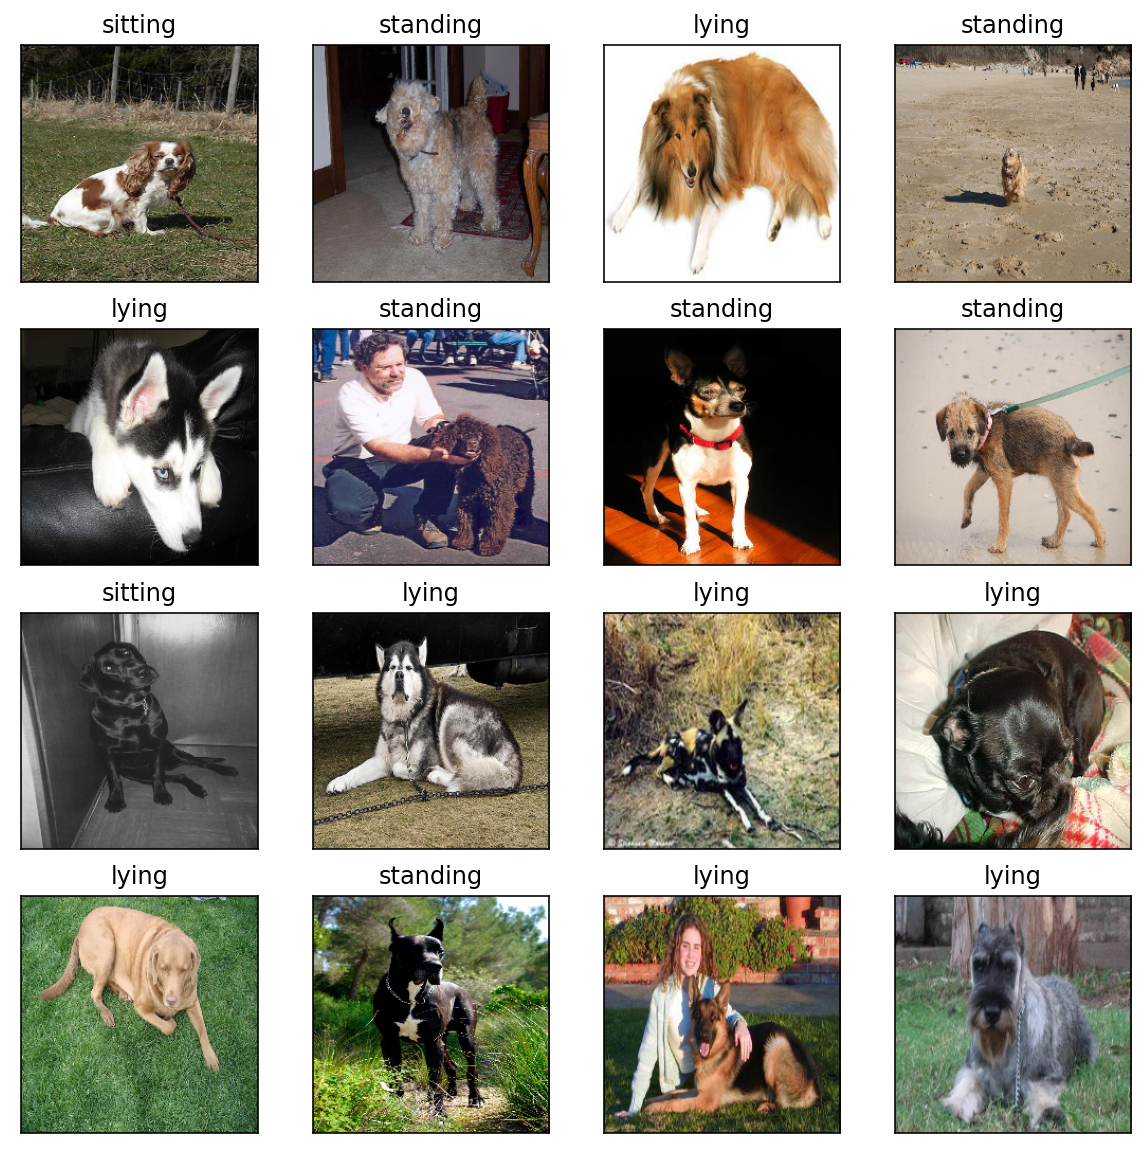

In [97]:
h, w = 4, 4
fig, axs = plt.subplots(h, w, figsize=(10, 10))
axs = axs.ravel()
for i in range(h*w):
    axs[i].imshow(Xtrain[i])
    axs[i].set_title(class_labels[Ttrain[i][0]])
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

# Topology Search

In [94]:
layers = [[32, 64, 128, 256, 512]] + [[32, 64, 128]] + [[nu] * nl for nu in [128, 256] for nl in range(2, 5)]
dense = [128]

product = list(itertools.product(dense, layers))
print(f'total of {len(product)} trials.')

epochs = 60
batch_size = 64
optim = tf.keras.optimizers.Adam(learning_rate=1e-4)

histories = []

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.02),
  tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal')
], name='augmentation')

f = FloatProgress(min=0, max=len(product))
display(f)
for dense, n_units_in_conv_layers in product:
    
    kernels_size_and_stride = [(3, 1)]*len(n_units_in_conv_layers)
    
    #setup
    tf.keras.backend.clear_session()

    X = Z = tf.keras.Input(shape=Xtrain.shape[1:])
    # Z = data_augmentation(Z)   
    for (kernel, stride), units in zip(kernels_size_and_stride, n_units_in_conv_layers):
        Z = tf.keras.layers.Conv2D(
            units, kernel_size=kernel, strides=stride, padding='same')(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)
        Z = tf.keras.layers.Activation('relu')(Z)
        Z = tf.keras.layers.MaxPooling2D(pool_size=2)(Z)
        Z = tf.keras.layers.Dropout(0.20)(Z)
        
    Z = tf.keras.layers.Dense(dense, activation='relu')(tf.keras.layers.Flatten()(Z))
    Y = tf.keras.layers.Dense(len(np.unique(Ttrain)), activation='softmax')(Z)

    model = tf.keras.Model(inputs=X, outputs=Y)
    
    #compile 
    model.compile(optimizer=optim,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    #train 
    history = model.fit(Xtrain, Ttrain, verbose=0,
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(Xvalidate, Tvalidate)).history
    histories.append(history)
    
    f.value += 1

total of 8 trials.


FloatProgress(value=0.0, max=8.0)

train --  , validation -


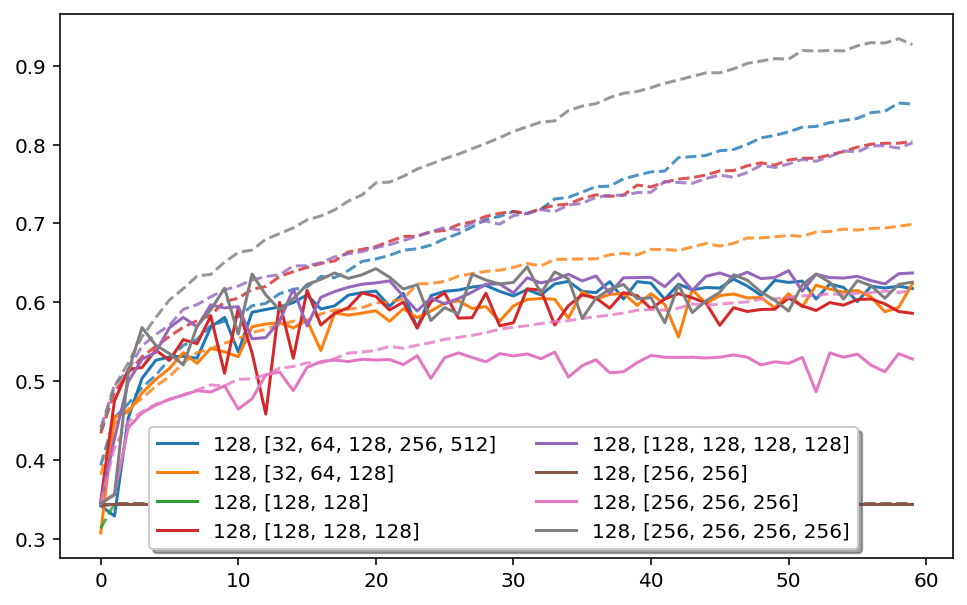

In [95]:
fig, ax = plt.subplots(figsize=(8, 5))

cmap = cm.get_cmap('tab10')
colors = [cmap.colors[i] for i in range(len(cmap.colors))]
lables = [str(p)[1:-1] for p in product]

i = 0
for h in histories:
    ax.plot(h['accuracy'], '--', color=colors[i], alpha=0.8)
    ax.plot(h['val_accuracy'], color=colors[i], label=lables[i])
    i += 1
    
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes][0]
lines, labels = lines_labels[0], lines_labels[1]

fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0,.12,1.02,0.2),
           ncol=2, fancybox=True, shadow=True);

print('train --  , validation -')

In [96]:
Y = model.predict(Xtest).argmax(axis=1).reshape(-1,1)
results.confusion_matrix(Ttest, Y, np.arange(len(class_labels)));
print('\n', ', '.join([ f'{i} {class_labels[i]}' for i in range(len(class_labels))]))

       0    1    2    3
    ------------------------
 0 | 46.5 15.0 18.0 20.5
 1 |  7.9 48.4 26.6 17.1
 2 |  3.5  8.1 81.3  7.1
 3 |  8.6  7.9 21.7 61.8

 0 lying, 1 sitting, 2 standing, 3 undefined


# Basic Model

In [107]:
tf.keras.backend.clear_session()
tf.config.run_functions_eagerly(False)

epochs = 35
batch_size = 32
optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
n_units_in_conv_layers = [32, 64, 128, 256]
kernels_size_and_stride = [(3, 1)]*len(n_units_in_conv_layers)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.02),
  tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal')
], name='augmentation')

X = Z = tf.keras.Input(shape=Xtrain.shape[1:])
Z = data_augmentation(Z)
for (kernel, stride), units in zip(kernels_size_and_stride, n_units_in_conv_layers):
    Z = tf.keras.layers.Conv2D(
        units, kernel_size=kernel, strides=stride, padding='same')(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation('relu')(Z)
    Z = tf.keras.layers.MaxPooling2D(pool_size=2)(Z)
    Z = tf.keras.layers.Dropout(0.20)(Z)

# https://github.com/richardaecn/class-balanced-loss/blob/
#    1d7857208a2abc03d84e35a9d5383af8225d4b4d/src/model_base.py#L196
#, bias_initializer=tf.constant_initializer(-np.log(dense_units - 1))

dense_units = 128
Z = tf.keras.layers.Dense(dense_units, activation='relu')(tf.keras.layers.Flatten()(Z))
Y = tf.keras.layers.Dense(len(np.unique(Ttrain)), activation='softmax')(Z)

model = tf.keras.Model(inputs=X, outputs=Y)

model.compile(optimizer=optim,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5,
                                              restore_best_weights=True)]

start_t = time.time()
history = model.fit(Xtrain, Ttrain, verbose=2,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(Xvalidate, Tvalidate),
                    callbacks=callbacks).history

print(f'Finished in {time.time() - start_t:.3f} seconds.')

Epoch 1/35
335/335 - 14s - loss: 1.1178 - accuracy: 0.4956 - val_loss: 1.0357 - val_accuracy: 0.4982
Epoch 2/35
335/335 - 14s - loss: 0.9726 - accuracy: 0.5242 - val_loss: 0.9757 - val_accuracy: 0.5312
Epoch 3/35
335/335 - 14s - loss: 0.9502 - accuracy: 0.5412 - val_loss: 0.9417 - val_accuracy: 0.5466
Epoch 4/35
335/335 - 14s - loss: 0.9305 - accuracy: 0.5526 - val_loss: 0.9658 - val_accuracy: 0.5396
Epoch 5/35
335/335 - 14s - loss: 0.9158 - accuracy: 0.5649 - val_loss: 0.9109 - val_accuracy: 0.5802
Epoch 6/35
335/335 - 14s - loss: 0.8946 - accuracy: 0.5828 - val_loss: 0.9031 - val_accuracy: 0.5879
Epoch 7/35
335/335 - 14s - loss: 0.8701 - accuracy: 0.5975 - val_loss: 0.8559 - val_accuracy: 0.6265
Epoch 8/35
335/335 - 13s - loss: 0.8554 - accuracy: 0.6104 - val_loss: 0.8928 - val_accuracy: 0.5879
Epoch 9/35
335/335 - 13s - loss: 0.8410 - accuracy: 0.6202 - val_loss: 0.9035 - val_accuracy: 0.5893
Epoch 10/35
335/335 - 14s - loss: 0.8230 - accuracy: 0.6266 - val_loss: 0.9616 - val_accura

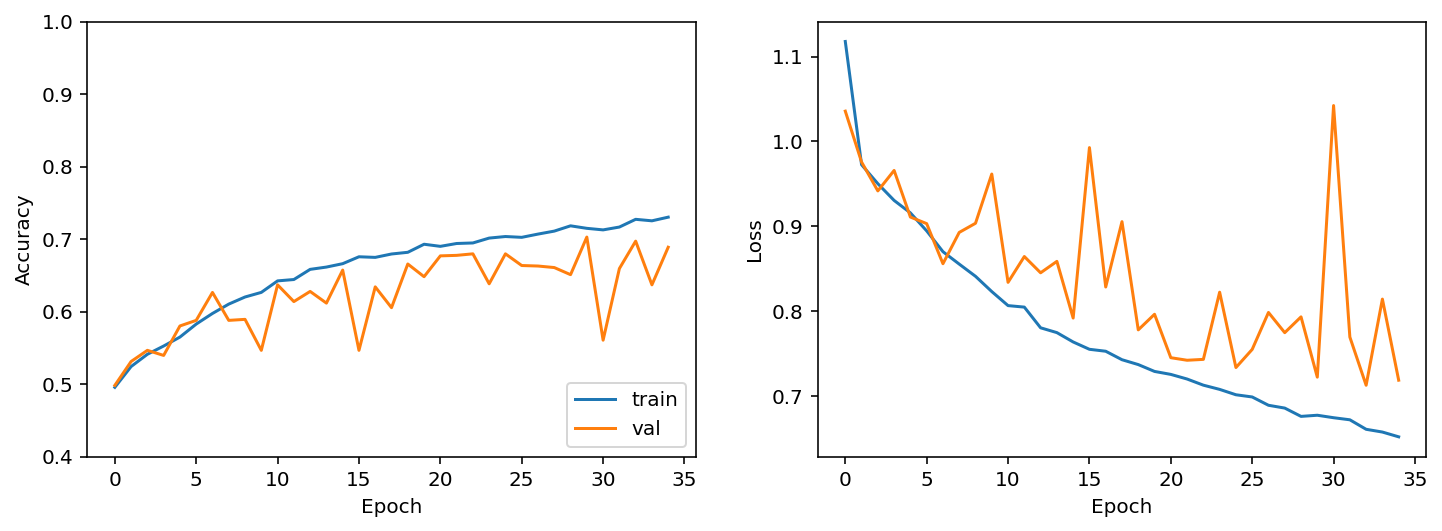

In [108]:
results.plot_history(history)

In [109]:
model.evaluate(Xtest, Ttest);

67/67 [==============================] - 1s 13ms/step - loss: 0.7027 - accuracy: 0.6995


In [110]:
Y = model.predict(Xtest).argmax(axis=1).reshape(-1,1)
results.confusion_matrix(Ttest, Y, np.arange(len(class_labels)));
print('\n', ', '.join([ f'{i} {class_labels[i]}' for i in range(len(class_labels))]))

       0    1    2
    ------------------
 0 | 71.8  6.3 21.9
 1 | 27.0 29.8 43.2
 2 |  9.6  4.3 86.1

 0 lying, 1 sitting, 2 standing


In [181]:
f = ConvNet_saved_model
# model.save(f)
model = tf.keras.models.load_model(f)

# Transfer Learning

In [3]:
# DON'T NORMALIZE for MobileNet / ResNet (use custom preprocessing layer)
# Requires shape of images to be (None, 224, 224, 3)
#
images, labels, class_labels = datahandler.load_data(NPY_IMAGE_PATH, NPY_LABEL_PATH, 
                                                     normalize=False, remove_undefined=True)

Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest = datahandler.partition_data(images, labels, 
                                                                           partition=(0.75,0.10,0.15), 
                                                                           shuffle=True)

print(class_labels)
print(Xtrain.shape, Ttrain.shape, Xvalidate.shape, Tvalidate.shape, Xtest.shape, Ttest.shape)

['lying' 'sitting' 'standing']
(10703, 224, 224, 3) (10703, 1) (1427, 224, 224, 3) (1427, 1) (2140, 224, 224, 3) (2140, 1)


## MobileNetV2

In [88]:
tf.keras.backend.clear_session()
tf.config.run_functions_eagerly(False)

epochs = 20
batch_size = 32

base_shape = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=base_shape,
                                               include_top=False,
                                               weights='imagenet')

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.02),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.1, 0.1),
                                                                 width_factor=(-0.1, 0.1)),
], name='augmentation')

preprocess_input = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda X: 
        tf.keras.applications.mobilenet_v2.preprocess_input(X))
], name='preprocess')

X = Z = tf.keras.Input(shape=Xtrain.shape[1:], name='input')
Z = preprocess_input(tf.cast(Z, tf.float32))
Z = data_augmentation(Z)

Z = base_model(Z, training=True)

Z = tf.keras.layers.GlobalAveragePooling2D()(Z)
Z = tf.keras.layers.Dense(64, activation='relu')(Z)
Z = tf.keras.layers.Dropout(0.35)(Z)
Z = tf.keras.layers.BatchNormalization()(Z)
Y = tf.keras.layers.Dense(len(np.unique(Ttrain)), activation='softmax')(Z)

model = tf.keras.Model(X, Y, name='MobileNetV2-Dog')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
                     
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5,
                                              restore_best_weights=True)]
    
start_t = time.time()
history = model.fit(Xtrain, Ttrain, verbose=2,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(Xvalidate, Tvalidate),
                    callbacks=callbacks).history

print(f'Finished in {time.time() - start_t:.3f} seconds.')

Epoch 1/20
335/335 - 56s - loss: 1.3368 - accuracy: 0.4352 - val_loss: 0.8744 - val_accuracy: 0.6216
Epoch 2/20
335/335 - 49s - loss: 1.0343 - accuracy: 0.5693 - val_loss: 0.7501 - val_accuracy: 0.6840
Epoch 3/20
335/335 - 49s - loss: 0.8940 - accuracy: 0.6371 - val_loss: 0.6610 - val_accuracy: 0.7288
Epoch 4/20
335/335 - 49s - loss: 0.7783 - accuracy: 0.6861 - val_loss: 0.5960 - val_accuracy: 0.7694
Epoch 5/20
335/335 - 49s - loss: 0.7031 - accuracy: 0.7215 - val_loss: 0.5520 - val_accuracy: 0.7926
Epoch 6/20
335/335 - 49s - loss: 0.6322 - accuracy: 0.7495 - val_loss: 0.5261 - val_accuracy: 0.8017
Epoch 7/20
335/335 - 49s - loss: 0.5751 - accuracy: 0.7784 - val_loss: 0.5042 - val_accuracy: 0.8073
Epoch 8/20
335/335 - 49s - loss: 0.5268 - accuracy: 0.7976 - val_loss: 0.4835 - val_accuracy: 0.8157
Epoch 9/20
335/335 - 49s - loss: 0.4930 - accuracy: 0.8112 - val_loss: 0.4686 - val_accuracy: 0.8255
Epoch 10/20
335/335 - 49s - loss: 0.4487 - accuracy: 0.8271 - val_loss: 0.4589 - val_accura

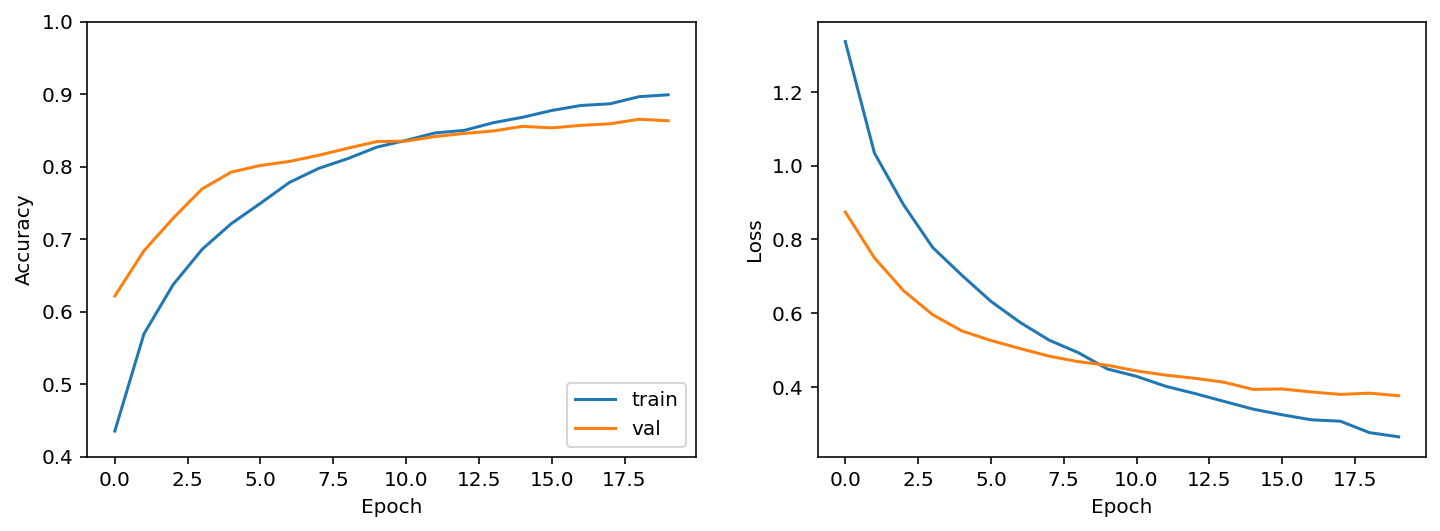

In [89]:
results.plot_history(history)

In [90]:
model.evaluate(Xtest, Ttest);

67/67 [==============================] - 6s 91ms/step - loss: 0.3458 - accuracy: 0.8673


In [91]:
Y = model.predict(Xtest).argmax(axis=1).reshape(-1,1)
results.confusion_matrix(Ttest, Y, np.arange(len(class_labels)));
print('\n', ', '.join([ f'{i} {class_labels[i]}' for i in range(len(class_labels))]))

       0    1    2
    ------------------
 0 | 87.3  7.2  5.5
 1 | 10.1 75.2 14.7
 2 |  3.3  5.4 91.3

 0 lying, 1 sitting, 2 standing


In [172]:
# model.save(MobileNetV2_saved_model)
model = tf.keras.models.load_model(MobileNetV2_saved_model)

## EfficientNetB4

In [ ]:
tf.keras.backend.clear_session()
tf.config.run_functions_eagerly(False)

epochs = 20
batch_size = 32

base_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB4(input_shape=base_shape,
                                               include_top=False,
                                               weights='imagenet')

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.02),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.1, 0.1),
                                                                 width_factor=(-0.1, 0.1)),
], name='augmentation')

preprocess_input = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda X: 
        tf.keras.applications.efficientnet.preprocess_input(X))
], name='preprocess')

X = Z = tf.keras.Input(shape=Xtrain.shape[1:], name='input')
Z = preprocess_input(tf.cast(Z, tf.float32))
Z = data_augmentation(Z)

Z = base_model(Z, training=True)

Z = tf.keras.layers.GlobalAveragePooling2D()(Z)
Z = tf.keras.layers.Dense(64, activation='relu')(Z)
Z = tf.keras.layers.Dropout(0.35)(Z)
Z = tf.keras.layers.BatchNormalization()(Z)
Y = tf.keras.layers.Dense(len(np.unique(Ttrain)), activation='softmax')(Z)

model = tf.keras.Model(X, Y, name='EfficientNetB4-Dog')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
                     
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5,
                                              restore_best_weights=True)]
    
start_t = time.time()
history = model.fit(Xtrain, Ttrain, verbose=2,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(Xvalidate, Tvalidate),
                    callbacks=callbacks).history

print(f'Finished in {time.time() - start_t:.3f} seconds.')

Epoch 1/20
335/335 - 131s - loss: 1.3236 - accuracy: 0.4100 - val_loss: 0.9358 - val_accuracy: 0.5522
Epoch 2/20
335/335 - 127s - loss: 1.0727 - accuracy: 0.5220 - val_loss: 0.7928 - val_accuracy: 0.6468
Epoch 3/20


In [ ]:
results.plot_history(history)

In [ ]:
model.evaluate(Xtest, Ttest);

In [ ]:
Y = model.predict(Xtest).argmax(axis=1).reshape(-1,1)
results.confusion_matrix(Ttest, Y, np.arange(len(class_labels)));
print('\n', ', '.join([ f'{i} {class_labels[i]}' for i in range(len(class_labels))]))

In [ ]:
model.save(EfficientNetB4_saved_model)
# model = tf.keras.models.load_model(EfficientNetB4_saved_model)

## ResNet50V2

In [79]:
tf.keras.backend.clear_session()
tf.config.run_functions_eagerly(False)

epochs = 20
batch_size = 32

base_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet50V2(input_shape=base_shape,
                                              include_top=False,
                                              weights='imagenet')

for layer in base_model.layers:
    # delete training=False in base_model
    #
    # if layer.name == 'conv5_block3_2_conv':
    #     break
    # else:
    #     layer.trainable = False

    # 83% 
    # https://medium.com/@balaji.kulkarni92/transfer-learning-using-resnet-e20598314427
    # if isinstance(layer, tf.keras.layers.BatchNormalization):
    #     layer.trainable = True
    # else:
    #     layer.trainable = False
    pass

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.02),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.1, 0.1),
                                                                 width_factor=(-0.1, 0.1)),
], name='augmentation')

preprocess_input = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda X: 
        tf.keras.applications.resnet_v2.preprocess_input(X))
], name='preprocess')

X = Z = tf.keras.Input(shape=Xtrain.shape[1:], name='input')
Z = preprocess_input(tf.cast(Z, tf.float32))
Z = data_augmentation(Z)

# 89% without undefined.
Z = base_model(Z, training=True)

Z = tf.keras.layers.GlobalAveragePooling2D()(Z)
Z = tf.keras.layers.Dense(64, activation='relu')(Z)
Z = tf.keras.layers.Dropout(0.35)(Z)
Z = tf.keras.layers.BatchNormalization()(Z)
Y = tf.keras.layers.Dense(len(np.unique(Ttrain)), activation='softmax')(Z)

model = tf.keras.Model(X, Y, name='ResNet50V2-Dog')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
                     
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5,
                                              restore_best_weights=True)]
    
start_t = time.time()
history = model.fit(Xtrain, Ttrain, verbose=2,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(Xvalidate, Tvalidate),
                    callbacks=callbacks).history

print(f'Finished in {time.time() - start_t:.3f} seconds.')

Epoch 1/20
335/335 - 57s - loss: 1.1911 - accuracy: 0.4798 - val_loss: 0.7722 - val_accuracy: 0.6545
Epoch 2/20
335/335 - 57s - loss: 0.8936 - accuracy: 0.6144 - val_loss: 0.6617 - val_accuracy: 0.7274
Epoch 3/20
335/335 - 57s - loss: 0.7022 - accuracy: 0.7106 - val_loss: 0.5799 - val_accuracy: 0.7638
Epoch 4/20
335/335 - 57s - loss: 0.5830 - accuracy: 0.7638 - val_loss: 0.5509 - val_accuracy: 0.7821
Epoch 5/20
335/335 - 59s - loss: 0.5118 - accuracy: 0.8039 - val_loss: 0.4875 - val_accuracy: 0.8087
Epoch 6/20
335/335 - 58s - loss: 0.4367 - accuracy: 0.8317 - val_loss: 0.4493 - val_accuracy: 0.8276
Epoch 7/20
335/335 - 60s - loss: 0.3826 - accuracy: 0.8566 - val_loss: 0.4263 - val_accuracy: 0.8465
Epoch 8/20
335/335 - 57s - loss: 0.3366 - accuracy: 0.8768 - val_loss: 0.4129 - val_accuracy: 0.8514
Epoch 9/20
335/335 - 57s - loss: 0.3040 - accuracy: 0.8891 - val_loss: 0.4070 - val_accuracy: 0.8584
Epoch 10/20
335/335 - 57s - loss: 0.2689 - accuracy: 0.9021 - val_loss: 0.3905 - val_accura

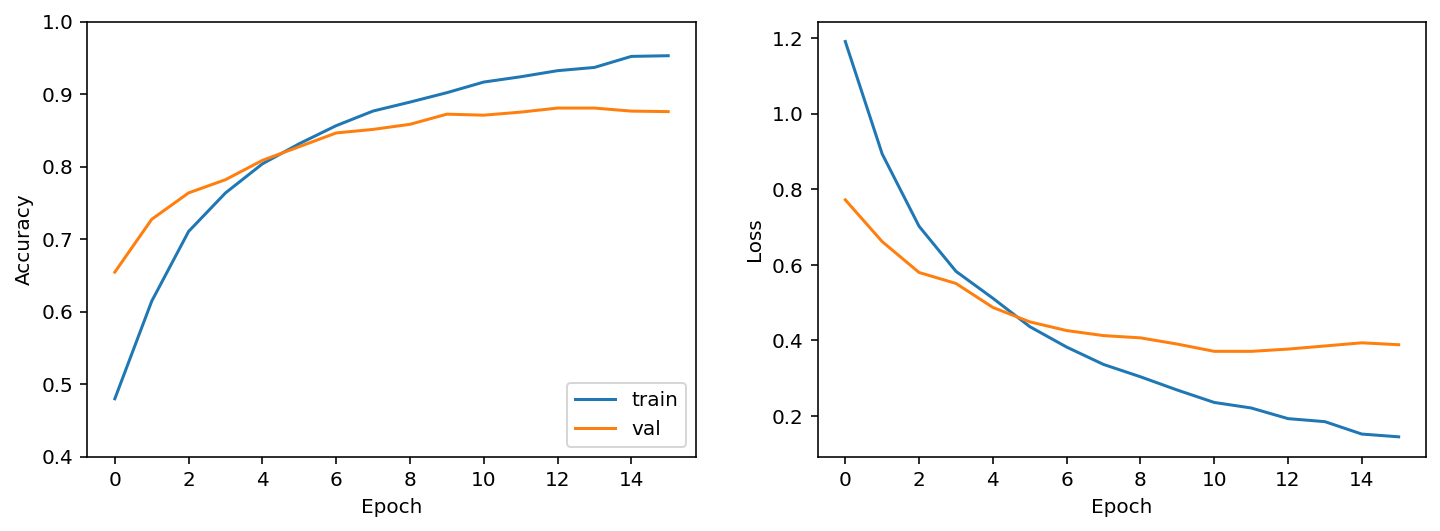

In [80]:
results.plot_history(history)

In [81]:
model.evaluate(Xtest, Ttest);

67/67 [==============================] - 3s 50ms/step - loss: 0.3214 - accuracy: 0.8916


In [82]:
Y = model.predict(Xtest).argmax(axis=1).reshape(-1,1)
results.confusion_matrix(Ttest, Y, np.arange(len(class_labels)));
print('\n', ', '.join([ f'{i} {class_labels[i]}' for i in range(len(class_labels))]))

       0    1    2
    ------------------
 0 | 88.9  6.9  4.2
 1 | 10.1 82.2  7.7
 2 |  2.2  5.6 92.3

 0 lying, 1 sitting, 2 standing


In [159]:
# model.save(ResNet50V2_saved_model)
model = tf.keras.models.load_model(ResNet50V2_saved_model)

## Explainers

In [84]:
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.vanilla_gradients import VanillaGradients
from tf_explain.core.activations import ExtractActivations 
from tf_explain.core.gradients_inputs import GradientsInputs
from tf_explain.core.integrated_gradients import IntegratedGradients
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from tf_explain.core.smoothgrad import SmoothGrad

In [298]:
def interpret_input(nnet, X, T, class_labels, save=False):

    class_name = class_labels[T[0][0]]
    
    Y = nnet.predict(X)
    Y_i = Y.argmax(axis=1)[0]
    img = X[0] if X.max() <= 1 else X[0] / 255.
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(img)
    ax.set_title(f'T: {class_name}, Y: {class_labels[Y_i]} ({Y[0, Y_i]*100:.3f}%)')
    ax.set_xticks([]); ax.set_yticks([]); ax.grid(False)
    
    explainers = [GradCAM(), VanillaGradients(), GradientsInputs(),
          IntegratedGradients(), OcclusionSensitivity(), SmoothGrad()]
    
    explainers_name = ['Grad CAM', 'Vanilla Gradients', 'Gradients Inputs',
                       'Integrated Gradients', 'Occlusion Sensitivity', 'Smooth Grad']

    fig, axs = plt.subplots(2,3,figsize=(8, 6))
    axs = axs.ravel()
    [axi.set_axis_off() for axi in axs]
    
    for i in range(len(explainers)):
        try:
            if 'Occlusion Sensitivity' == explainers_name[i]: 
                grid = explainers[i].explain((X, T), nnet, class_index=T[0][0], patch_size=15)
            else:
                grid = explainers[i].explain((X, T), nnet, class_index=T[0][0])
            axs[i].imshow(img)
            im = axs[i].imshow(grid, cmap='Reds', alpha=0.6)
            # fig.colorbar(im, ax=axs[i], shrink=0.62)
        except Exception as e:
            print(f'{explainers_name[i]} -- {e}')
        
        axs[i].set_title(explainers_name[i], size=11)
        
    fig.tight_layout();
    
    if save:
        plt.savefig('media/' + f'interpret_{str(class_name)}.png', bbox_inches='tight', dpi=300)
        
        
def interpret_input_individual(nnet, X, T, class_labels, indicies, explainer, title, save=False):

    class_name = class_labels[T[0][0]]
    
    Y = nnet.predict(X)
    Y_i = Y.argmax(axis=1)
    imgs = X if X.max() <= 1 else X / 255.
    
    fig, axs = plt.subplots(1,3,figsize=(9, 3))
    axs = axs.ravel()
    [axi.set_axis_off() for axi in axs]
    
    for i, img_i in enumerate(indicies):
        try: # not going to work with Occlusion Sensitivity
            grid = explainer.explain((X[img_i:img_i+1], T[img_i:img_i+1]), nnet, class_index=T[img_i][0])
            axs[i].imshow(imgs[img_i])
            im = axs[i].imshow(grid, cmap='Reds', alpha=0.6)
        except Exception as e:
            print(f'{e}')

        ax_title = f'T: {class_labels[T[img_i][0]]}, Y: {class_labels[Y_i[img_i]]} ({Y[img_i, Y_i[img_i]]*100:.2f}%)'
        axs[i].set_title(ax_title, size=13)
        
    fig.tight_layout();
    
    if save:
        plt.savefig('media/' + f'interpret_{title}_ConvNet-Dog.png', bbox_inches='tight', dpi=300)

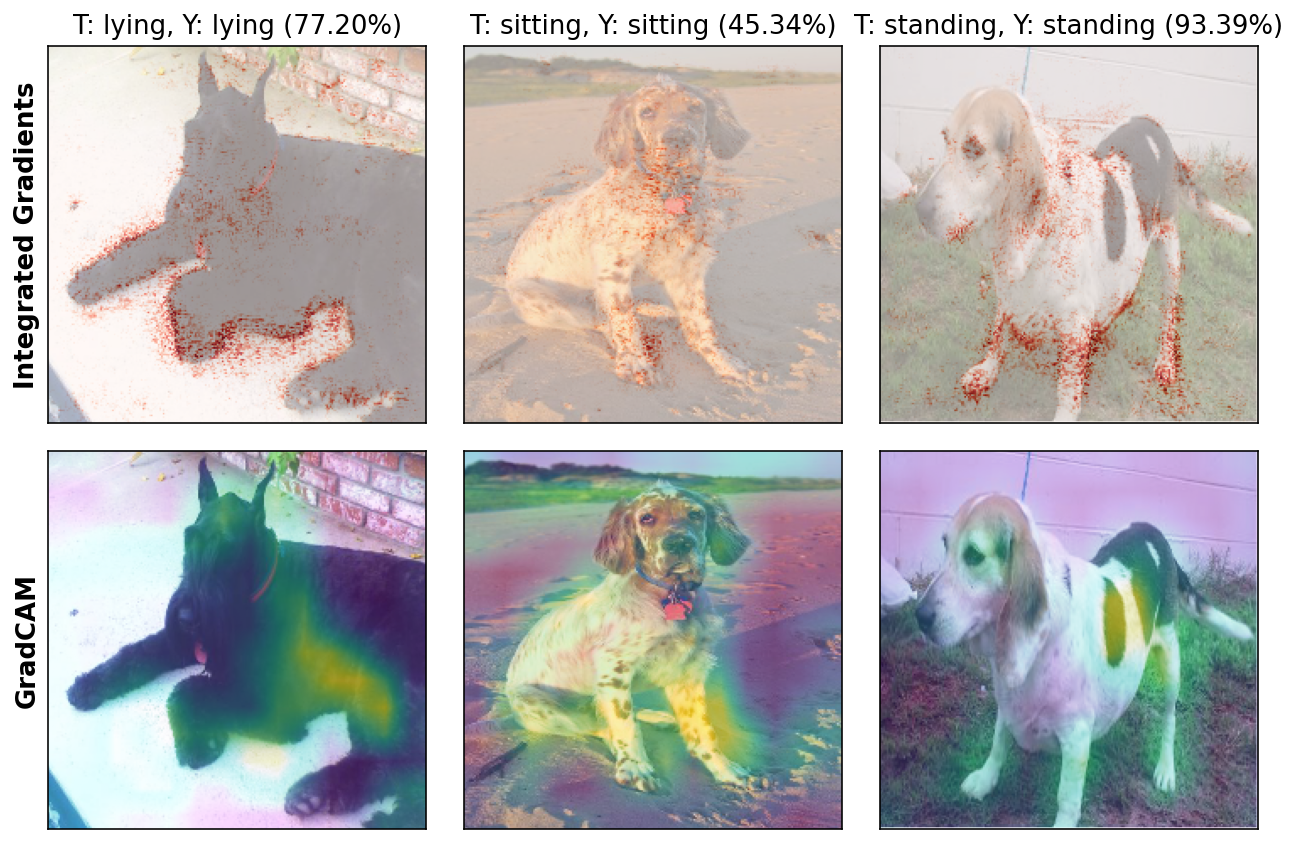

In [322]:
X = Xtest
T = Ttest

class_name = class_labels[T[0][0]]

Y = model.predict(X)
Y_i = Y.argmax(axis=1)
imgs = X if X.max() <= 1 else X / 255.

fig, axs = plt.subplots(2,3,figsize=(9, 6))
# [axi.set_axis_off() for axi in axs.ravel()]
for e in range(2):
    explainer = GradCAM() if e == 1 else IntegratedGradients()
    for i, img_i in enumerate([2130, 1448, 17]):
        try: # not going to work with Occlusion Sensitivity
            grid = explainer.explain((X[img_i:img_i+1], T[img_i:img_i+1]), model, class_index=T[img_i][0])
            axs[e,i].imshow(imgs[img_i])
            im = axs[e,i].imshow(grid, cmap='Reds', alpha=0.6)
        except Exception as ex:
            print(f'{ex}')
        if e == 0:
            ax_title = f'T: {class_labels[T[img_i][0]]}, Y: {class_labels[Y_i[img_i]]} ({Y[img_i, Y_i[img_i]]*100:.2f}%)'
            axs[e,i].set_title(ax_title, size=13)
        axs[e,i].set_xticks([]); axs[e,i].set_yticks([]); axs[e,i].grid(False)
            
axs[0, 0].set_ylabel('Integrated Gradients', fontweight='bold', size=13)
axs[1, 0].set_ylabel('GradCAM', fontweight='bold', size=13)       

fig.tight_layout();

# plt.savefig('../media/' + f'interpret_ConvNet-Dog.png', bbox_inches='tight', dpi=300)

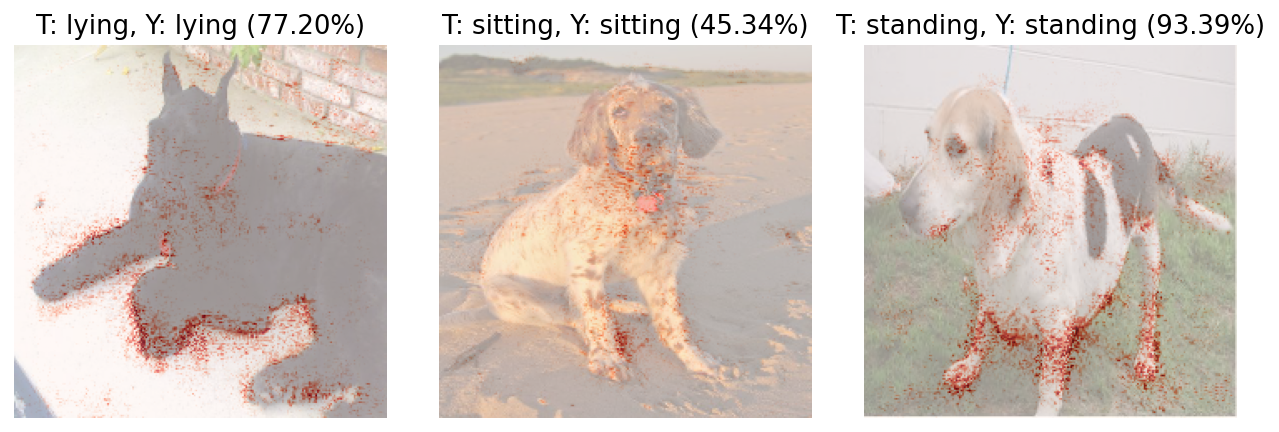

In [299]:
tf.config.run_functions_eagerly(True)
interpret_input_individual(model, Xtest, Ttest, class_labels, [2130, 1448, 17],
                           IntegratedGradients(), title='integrated_gradients', save=False)

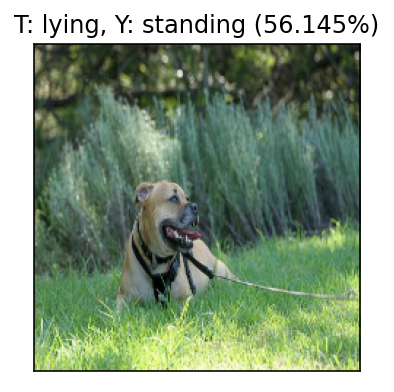

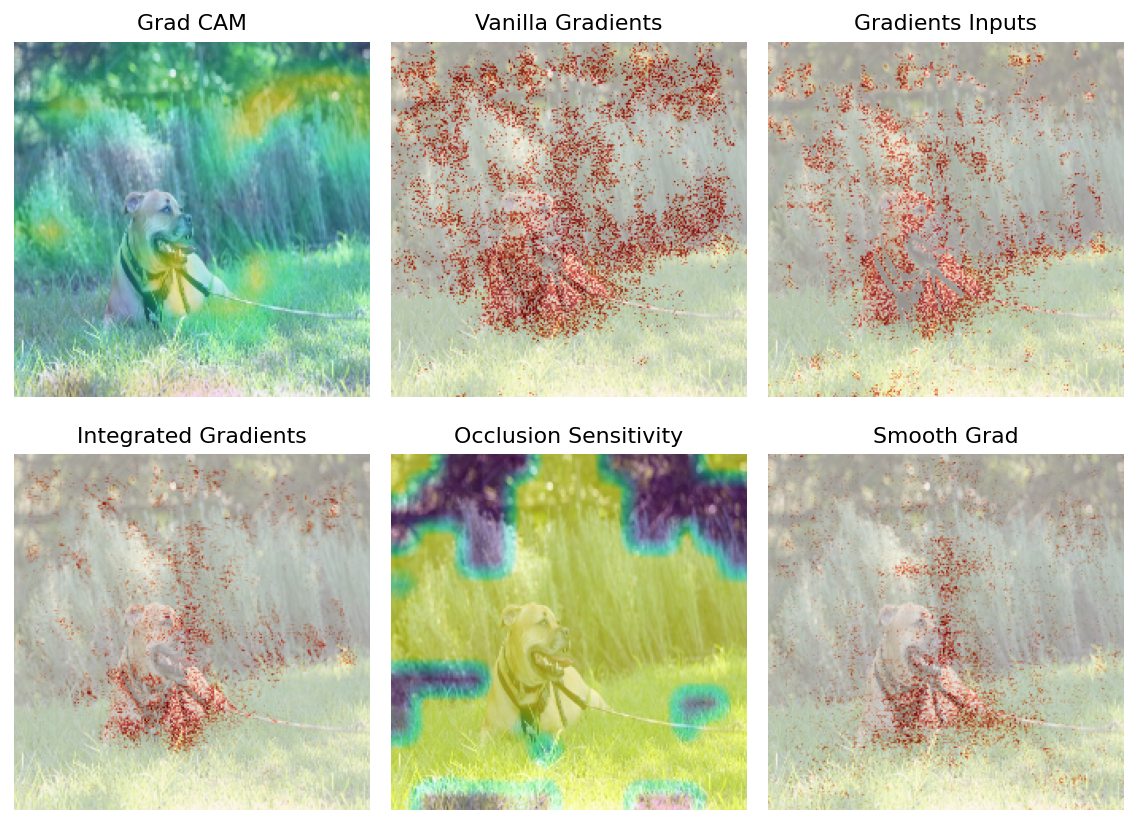

In [189]:
tf.config.run_functions_eagerly(True)

i = 22
interpret_input(model, Xtest[i:i+1], Ttest[i:i+1], class_labels, save=False)

# TFLite Conversion

In [324]:
ConvNet_tflite_f = '../../models/ConvNet-Dog.tflite'
MobileNetV2_tflite_f = '../../models/MobileNetV2-Dog.tflite'
ResNet50V2_tflite_f = '../../models/ResNet50V2-Dog.tflite'

ConvNet_tflite_16_f = '../../models/ConvNet-Dog_16.tflite'
MobileNetV2_tflite_16_f = '../../models/MobileNetV2-Dog_16.tflite'
ResNet50V2_tflite_16_f = '../../models/ResNet50V2-Dog_16.tflite'

In [334]:
# ConvNet
converter = tf.lite.TFLiteConverter.from_saved_model(ConvNet_saved_model)
tflite_model = converter.convert()
open(ConvNet_tflite_f, 'wb').write(tflite_model);
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()
open(ConvNet_tflite_16_f, 'wb').write(tflite_quant_model);
print('Finished ConvNet')

# MobileNetV2
# converter = tf.lite.TFLiteConverter.from_saved_model(MobileNetV2_saved_model)
# tflite_model = converter.convert()
# open(MobileNetV2_tflite_f, 'wb').write(tflite_model);
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]
# tflite_quant_model = converter.convert()
# open(MobileNetV2_tflite_16_f, 'wb').write(tflite_quant_model);
# print('Finished MobileNet')

# ResNet50V2
converter = tf.lite.TFLiteConverter.from_saved_model(ResNet50V2_saved_model)
tflite_model = converter.convert()
open(ResNet50V2_tflite_f, 'wb').write(tflite_model);
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()
open(ResNet50V2_tflite_16_f, 'wb').write(tflite_quant_model);
print('Finished ResNet')

Finished ConvNet
Finished ResNet
